In [416]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [417]:
## Import the data file
tommiesraw = pd.read_excel("Veg dataset raw.xlsx", sheet_name='Tomatoes')
tommiesraw['Date'] = pd.to_datetime(tommiesraw['Date'])

## Set the index column
tommiesraw.set_index('Date', inplace=True)
print(tommiesraw)

                Main Ingredient  Average Price
Date                                          
2013-06-16  Tomato Small(Local)           29.0
2013-06-17  Tomato Small(Local)           22.5
2013-06-18  Tomato Small(Local)           24.0
2013-06-19  Tomato Small(Local)           26.0
2013-06-20  Tomato Small(Local)           24.0
...                         ...            ...
2021-05-09  Tomato Small(Local)           12.5
2021-05-10  Tomato Small(Local)           12.5
2021-05-11  Tomato Small(Local)           12.5
2021-05-12  Tomato Small(Local)           32.5
2021-05-13  Tomato Small(Local)           37.5

[2741 rows x 2 columns]


In [418]:
print(tommiesraw.describe())

       Average Price
count    2741.000000
mean       38.185516
std        16.970949
min        10.000000
25%        25.000000
50%        35.000000
75%        47.500000
max       117.500000


In [419]:
## Check for null values and data types
tommiesraw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2741 entries, 2013-06-16 to 2021-05-13
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  2741 non-null   object 
 1   Average Price    2741 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.2+ KB


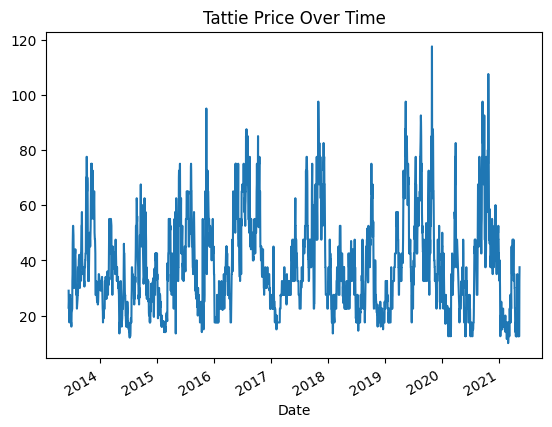

In [420]:
## Plot the time series
tommiesraw['Average Price'].plot(title='Tattie Price Over Time')
plt.show()

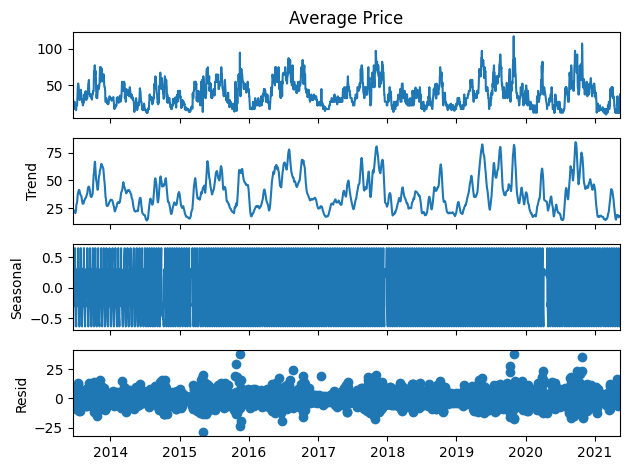

In [421]:
## Decompose the data to observe for trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(tommiesraw['Average Price'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()


<Axes: xlabel='Date'>

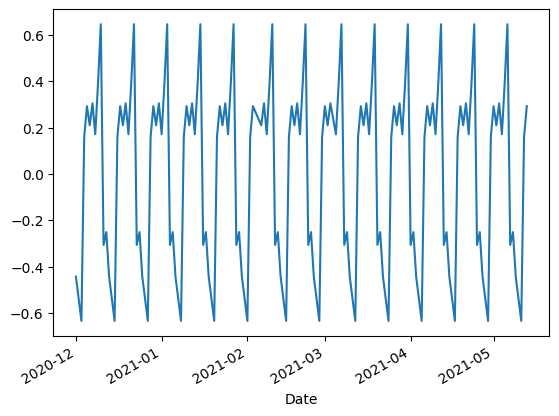

In [422]:
# Zoom in on seasonality to confirm seasonality
decomposition.seasonal.loc['2020-12':'2021-12'].plot()

In [423]:
## The decompoisition demonstrates a long-term increase in the average prices. There are certain points of price acceleration and price deceleration. The seasonal plot appears very flat, indicating there isn't strong seasonal variation. The residual plot doesn't indicate any specific pattern, with fluctuations being scattered and therefore random.

# The primary driver for average price of tommies appears to be a general increase over time, with very little impact from seasonsality, not any systematic error.

# Seasonality is confirmed as potentially quarterly

## Following these observations, it would be best to proceed with an ARIMA model.

In [424]:
## Check for outliers
from scipy.stats import zscore

# Calculate Z-scores
tommiesraw['z_score'] = zscore(tommiesraw['Average Price'])

# Define a threshold for identifying outliers. 3 is a standard threshold.
threshold = 3

# Detect outliers
outliers = tommiesraw[abs(tommiesraw['z_score']) > threshold]
print("Outliers detected:")
print(outliers)

Outliers detected:
                Main Ingredient  Average Price   z_score
Date                                                    
2015-11-15  Tomato Small(Local)           95.0  3.348360
2017-11-01  Tomato Small(Local)           97.5  3.495698
2017-11-02  Tomato Small(Local)           92.5  3.201023
2019-05-15  Tomato Small(Local)           97.5  3.495698
2019-08-20  Tomato Small(Local)           92.5  3.201023
2019-08-21  Tomato Small(Local)           90.0  3.053685
2019-10-30  Tomato Small(Local)          117.5  4.674397
2020-09-17  Tomato Small(Local)           95.0  3.348360
2020-09-18  Tomato Small(Local)           97.5  3.495698
2020-09-29  Tomato Small(Local)           92.5  3.201023
2020-10-25  Tomato Small(Local)          107.5  4.085047
2020-10-26  Tomato Small(Local)           95.0  3.348360


In [425]:
## It is important to check if these are true outliers or if they are indicitive of a sudden change in the trend.

outliers.info()
outliers.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2015-11-15 to 2020-10-26
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  12 non-null     object 
 1   Average Price    12 non-null     float64
 2   z_score          12 non-null     float64
dtypes: float64(2), object(1)
memory usage: 384.0+ bytes


,Average Price,z_score
count,12.000000,12.000000
mean,97.500000,3.495698
std,7.687061,0.453037
min,90.000000,3.053685
25%,92.500000,3.201023
50%,95.000000,3.348360
75%,97.500000,3.495698
max,117.500000,4.674397


In [426]:
## The outliers will be removed as they comprise a very small number of the dataset
tommies_filtered = tommiesraw[tommiesraw['z_score']<3]

In [427]:
## Check data quality

tommies_filtered.info()
print(tommies_filtered.describe())
print(tommies_filtered.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2729 entries, 2013-06-16 to 2021-05-13
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  2729 non-null   object 
 1   Average Price    2729 non-null   float64
 2   z_score          2729 non-null   float64
dtypes: float64(2), object(1)
memory usage: 85.3+ KB
       Average Price      z_score
count    2729.000000  2729.000000
mean       37.924698    -0.015371
std        16.537766     0.974653
min        10.000000    -1.661113
25%        25.000000    -0.777088
50%        35.000000    -0.187738
75%        47.500000     0.548949
max        87.500000     2.906348
                Main Ingredient  Average Price   z_score
Date                                                    
2013-06-16  Tomato Small(Local)           29.0 -0.541348
2013-06-17  Tomato Small(Local)           22.5 -0.924426
2013-06-18  Tomato Small(Local)           24.0 -0.836023
20

In [428]:
print(tommies_filtered.head())

                Main Ingredient  Average Price   z_score
Date                                                    
2013-06-16  Tomato Small(Local)           29.0 -0.541348
2013-06-17  Tomato Small(Local)           22.5 -0.924426
2013-06-18  Tomato Small(Local)           24.0 -0.836023
2013-06-19  Tomato Small(Local)           26.0 -0.718153
2013-06-20  Tomato Small(Local)           24.0 -0.836023


In [429]:
tommies = tommies_filtered.drop(['Main Ingredient', 'z_score'], axis=1)

In [430]:
## As highlighted above, the data has an upwards trend and there is seasonality present. 
## Let's confirm that it is not stationary using the Augmented Dickey Fuller test.

from statsmodels.tsa.stattools import adfuller
result = adfuller(tommies)

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the result
if result[1] <= 0.05:
    print("The time series is likely stationary (reject null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject null hypothesis)")



ADF Statistic: -6.624282624664821
p-value: 5.929895241904688e-09
Critical Values: {'1%': -3.4327617523031955, '5%': -2.8626055362914116, '10%': -2.567337219971881}
The time series is likely stationary (reject null hypothesis)


In [431]:
# Initial attempts have demonstrated the kernel runs too slowly with daily data. Therefore, for ease, let's adjust to monthly data, using the average.

monthlytommies = tommies.resample('M').mean()

print(monthlytommies)

            Average Price
Date                     
2013-06-30      23.636364
2013-07-31      35.360000
2013-08-31      31.523810
2013-09-30      39.580000
2013-10-31      52.685185
...                   ...
2021-01-31      22.403226
2021-02-28      16.250000
2021-03-31      27.200000
2021-04-30      24.583333
2021-05-31      18.653846

[96 rows x 1 columns]


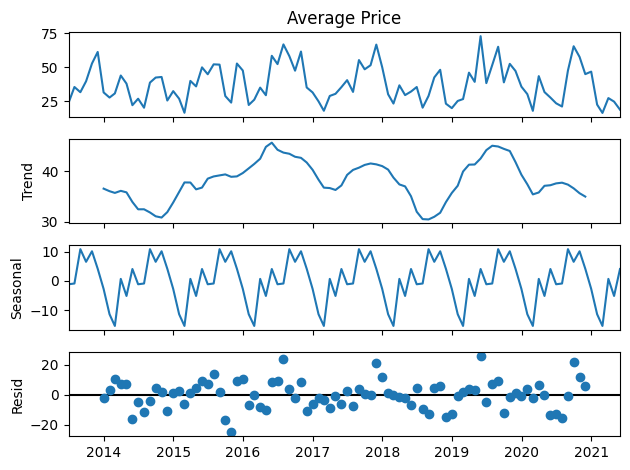

In [432]:
## Decompose the data to observe for trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthlytommies['Average Price'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

<Axes: xlabel='Date'>

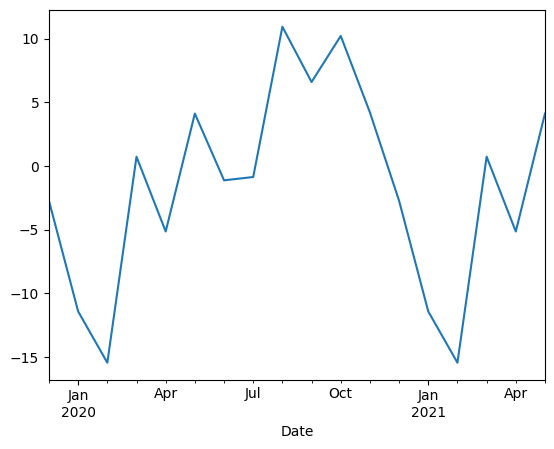

In [433]:
# Zoom in on seasonality to confirm seasonality
decomposition.seasonal.loc['2019-12':'2021-12'].plot()

Trend: fluctuating trend with general upward movement. 

Seasonality: Stationary, quarterly seasonality; data is weekly, so m = 12.

Residuals:  Small, close to zero residuals imply trend and seasonality was sufficiently separated.

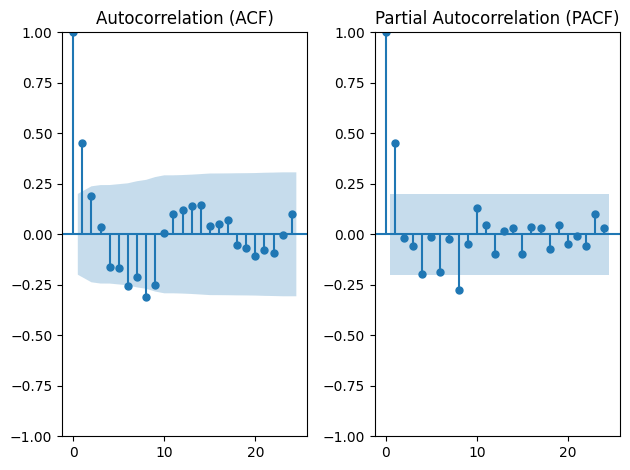

In [434]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(1, 2, 1)
plot_acf(monthlytommies, lags=24, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(monthlytommies, lags=24, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [435]:
# Check stationarity of weekly data
from statsmodels.tsa.stattools import adfuller
monthlyresult = adfuller(monthlytommies)

# Extract and print the results
print('ADF Statistic:', monthlyresult[0])
print('p-value:', monthlyresult[1])
print('Critical Values:', monthlyresult[4])

# Interpret the result
if monthlyresult[1] <= 0.05:
    print("The time series is likely stationary (reject null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject null hypothesis)")

ADF Statistic: -5.20144891229604
p-value: 8.732396578536495e-06
Critical Values: {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
The time series is likely stationary (reject null hypothesis)


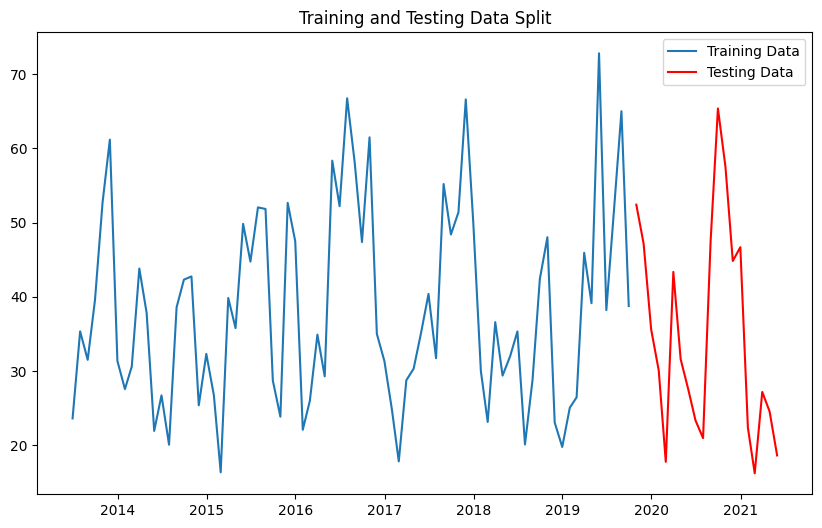

In [436]:
## Split the data into training and testing sets

## Let 80% of the data be the training data, with the remaining 20% reserved for testing
train_size = int(len(monthlytommies) * 0.8)
tommies_train, tommies_test = monthlytommies[:train_size], monthlytommies[train_size:]
tommies_train = tommies_train.asfreq('M')
tommies_test = tommies_test.asfreq('M')

# Plot the split to visualize
plt.close('all')
plt.figure(figsize=(10, 6))
plt.plot(tommies_train.index, tommies_train, label='Training Data')
plt.plot(tommies_test.index, tommies_test, label='Testing Data', color='red')
plt.legend()
plt.title('Training and Testing Data Split')
plt.show()


In [437]:
## Now to perform the ARIMA model

## Import the necessary libraries
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [438]:
# Fit the model using auto ARIMA
arima_model = auto_arima(tommies_train['Average Price'],d=0, D=1,
                         m=12, seasonal = True,
                         trace = True,
                         supress_warnings=True,
                         stepwise = False, n_jobs=-1
                        )                     

# Print the summary of the best model found
arima_model.summary()


Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 35.183 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -257.545
Date:                            Sat, 03 May 2025   AIC                            525.089
Time:                                    21:50:29   BIC                            535.884
Sample:                                06-30-2013   HQIC                           529.342
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0398      1.893      0.549      0.583      -2.671       4.751
ar.L1          0.4854      0.109      4.466      0.000       0.272       0.698
ar.S.L12      -0.8420      0.125     -6.714      0.000      -1.088      -0.596
ar.S.L24      -0.3923      0.148     -2.647      0.008      -0.683      -0.102
sigma2       157.3210     30.268      5.198      0.000      97.997     216.645
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.81   Prob(JB):                         0.83
Heteroskedasticity (H):               1.30   Skew:                            -0.13
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [439]:
## Use the model to predict values
prediction_tommies = pd.DataFrame(arima_model.predict(n_periods=len(tommies_test)), index=tommies_test.index, columns=['predicted average price'])
print(prediction_tommies.head())

            predicted average price
Date                               
2019-10-31                51.843379
2019-11-30                46.919574
2019-12-31                38.706012
2020-01-31                28.627240
2020-02-29                23.345875


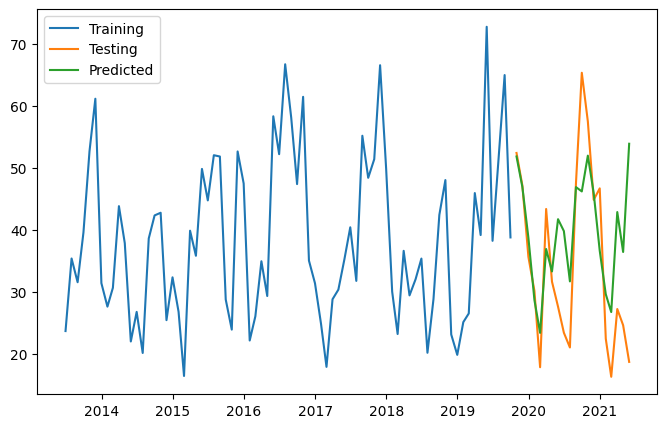

In [440]:
# Plot the model-predicted values against the actual values i.e. the test data set
plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(tommies_train,label="Training")
plt.plot(tommies_test,label="Testing")
plt.plot(prediction_tommies,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [441]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
tommies_test = tommies_test.copy() # create a copy to not override the original data
tommies_test['predicted average price'] = prediction_tommies
r2 = r2_score(tommies_test['Average Price'], tommies_test['predicted average price'])
mae = mean_absolute_error(tommies_test['Average Price'], tommies_test['predicted average price'])
mape = np.mean(np.abs((tommies_test['Average Price']-tommies_test['predicted average price'])/tommies_test['Average Price']))*100
print(f'R-squared: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

R-squared: 0.2606499790465139
MAE: 8.858384331639694
MAPE: 34.7156691090759


C:\Users\HannahFarrell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


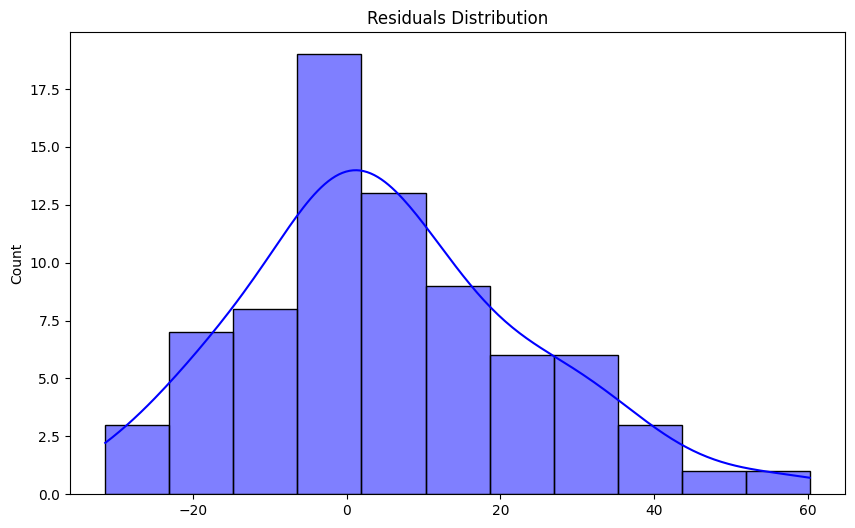

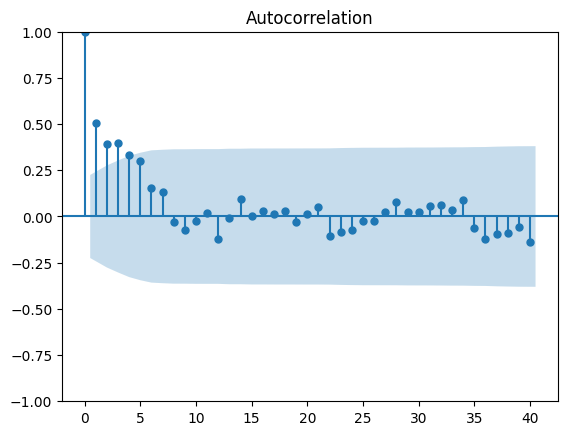

In [442]:
## Perform residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Residuals of the model
residuals = arima_model.resid()

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.show()

# Plot ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.show()


In [443]:
# Fix index frequency
tommies_train = tommies_train.asfreq('M')
tommies_test = tommies_test.asfreq('M')

# Confirm forecast works
future_forecast = arima_model.predict(n_periods=len(tommies_test)+12)
display(future_forecast)

# Generate future dates
last_date = tommies_test.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Combine
forecast_df = pd.DataFrame({'Forecast Price': future_forecast}, index=future_dates)
display(forecast_df)

2019-10-31    51.843379
2019-11-30    46.919574
2019-12-31    38.706012
2020-01-31    28.627240
2020-02-29    23.345875
2020-03-31    36.891442
2020-04-30    33.262366
2020-05-31    41.712011
2020-06-30    39.789600
2020-07-31    31.661168
2020-08-31    46.895627
2020-09-30    46.197357
2020-10-31    51.976980
2020-11-30    45.938772
2020-12-31    36.611151
2021-01-31    29.591775
2021-02-28    26.704194
2021-03-31    42.863536
2021-04-30    36.415244
2021-05-31    53.901258
2021-06-30    39.361408
2021-07-31    38.092713
2021-08-31    49.960352
2021-09-30    43.387206
2021-10-31    52.390130
2021-11-30    39.434062
2021-12-31    32.974839
2022-01-31    29.409088
2022-02-28    27.127817
2022-03-31    43.403322
2022-04-30    38.091241
2022-05-31    57.855444
Freq: M, dtype: float64

,Forecast Price
2021-06-30,39.361408
2021-07-31,38.092713
2021-08-31,49.960352
2021-09-30,43.387206
2021-10-31,52.390130
2021-11-30,39.434062
2021-12-31,32.974839
2022-01-31,29.409088
2022-02-28,27.127817
2022-03-31,43.403322


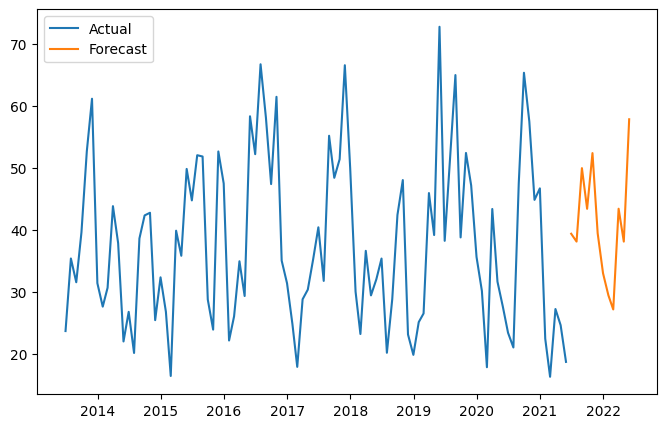

In [444]:
# Plot the model-predicted values against the actual values i.e. the test data set
plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(monthlytommies,label="Actual")
plt.plot(forecast_df,label="Forecast")
plt.legend(loc = 'upper left')
plt.show()

In [445]:
## Combine actual values with predicted values in the data frame

merged_df = pd.merge(monthlytommies, forecast_df, left_index=True, right_index=True, how='outer')
display(merged_df.tail(24))

,Average Price,Forecast Price
2020-06-30,23.366667,NaN
2020-07-31,20.983333,NaN
2020-08-31,47.500000,NaN
2020-09-30,65.370370,NaN
2020-10-31,57.500000,NaN
2020-11-30,44.833333,NaN
2020-12-31,46.693548,NaN
2021-01-31,22.403226,NaN
2021-02-28,16.250000,NaN
2021-03-31,27.200000,NaN


In [446]:
## Export to CSV
merged_df.to_csv('tommies_model_results.csv', index=True)
print(f'Data exported successfully')

Data exported successfully
